### Import libraries and Dataset


Import all the necessary libraries

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import string
import gdown
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
import joblib
import spacy
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

Download the dataset from drive and load dataset

In [120]:
df = pd.read_csv('SPAM text message 20170820 - Data.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [121]:
df.describe()

,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


### Data Cleaning

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Handle duplicate values

In [123]:
df['Message'].duplicated().sum()

415

In [124]:
before = df.shape[0]
df.drop_duplicates(subset=['Message'], inplace=True)
after = df.shape[0]
print(f"Number of duplicate messages removed: {before-after}")

Number of duplicate messages removed: 415


In [125]:
size = df.shape
print(f'rows: {size[0]}, columns: {size[1]}')

rows: 5157, columns: 2


Perform label encoding

In [126]:
category_encoder = LabelEncoder()
df['Category'] = category_encoder.fit_transform(df['Category'])
df.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Remove special characters

In [127]:
#removing non-ASCII characters and escape characters
def delete_non_ascii_and_escape(text):
    cleaned_text = re.sub(r'[^\x00-\x7F]+|[\r\n\t]', '', text)
    return cleaned_text


In [128]:
df['Message'] = df['Message'].apply(delete_non_ascii_and_escape)
df.rename(columns={'Message' : 'email'}, inplace=True)

In [129]:
df.head()

,Category,email
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### Data Visualization

In [130]:
label_count = df['Category'].value_counts()
label_count

0    4516
1     641
Name: Category, dtype: int64

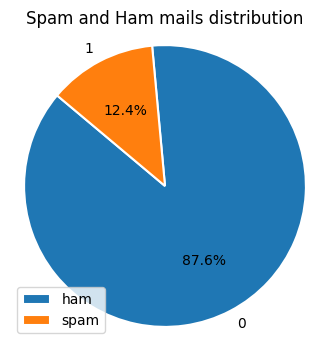

In [131]:
plt.figure(figsize=(4, 4))

wedge_properties = {'edgecolor': 'white', 'linewidth': 1.5}
plt.pie(
    label_count.values,
    labels=label_count.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops=wedge_properties
)
plt.title('Spam and Ham mails distribution')
plt.axis('equal')
plt.legend(['ham', 'spam'])

plt.show()

In [132]:
df['len_of_email'] = df['email'].apply(len)
df.head()

,Category,email,len_of_email
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [133]:
# Filter rows based on label
ham_emails = df[df['Category'] == 0]
spam_emails = df[df['Category'] == 1]

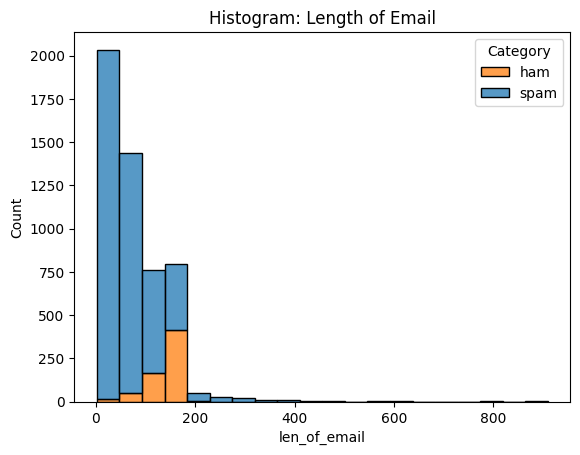

In [134]:
sns.histplot(data=df, x='len_of_email', hue='Category', multiple="stack", bins=20)
plt.title('Histogram: Length of Email')
plt.legend(title='Category', labels=['ham', 'spam'])
plt.show()

### Data Preprocessing

convert email column into lowercase

In [135]:
df['email'] = df['email'].map(str.lower)
df.head()

,Category,email,len_of_email
0,0,"go until jurong point, crazy.. available only ...",111
1,0,ok lar... joking wif u oni...,29
2,1,free entry in 2 a wkly comp to win fa cup fina...,155
3,0,u dun say so early hor... u c already then say...,49
4,0,"nah i don't think he goes to usf, he lives aro...",61


Remove stopwords and punctuation and lemmatize the data

In [136]:
nlp = spacy.load("en_core_web_sm")

def stopwords_and_punctuation_deletion(email):
    # Tokenize the text
    doc = nlp(email.lower())

    # Remove stopwords
    stop_words = set(nlp.Defaults.stop_words)
    processedWords = [token.lemma_ for token in doc if not token.is_stop and not token.like_num and token not in stop_words]

    # Remove punctuation
    processedWords = [word for word in processedWords if word not in string.punctuation]

    # Join the words back into a single string
    cleaned_text = " ".join(processedWords)

    return cleaned_text

def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [137]:
df['preprocessed_email_data'] = df['email'].apply(stopwords_and_punctuation_deletion)
df['preprocessed_email_data']= df['email'].apply(lemmatize_text)
df.head()

,Category,email,len_of_email,preprocessed_email_data
0,0,"go until jurong point, crazy.. available only ...",111,"go until jurong point , crazy .. available onl..."
1,0,ok lar... joking wif u oni...,29,ok lar ... joke wif u oni ...
2,1,free entry in 2 a wkly comp to win fa cup fina...,155,free entry in 2 a wkly comp to win fa cup fina...
3,0,u dun say so early hor... u c already then say...,49,u dun say so early hor ... u c already then sa...
4,0,"nah i don't think he goes to usf, he lives aro...",61,"nah I do not think he go to usf , he live arou..."


### Dataset Preparation

In [138]:
# Define the TF-IDF vectorizer with the desired parameters
vectorizer_tf_idf = TfidfVectorizer(max_features=2000,)

# Save the TF-IDF vectorizer
joblib.dump(vectorizer_tf_idf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [139]:
# Fit and transform the text data with the vectorizer
X = vectorizer_tf_idf.fit_transform(df['preprocessed_email_data']).toarray()

In [140]:
X.shape

(5157, 2000)

In [141]:
Y = df['Category'].values

In [142]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.2,random_state=2)

### Model Training

In [143]:
classifiers = {
    "SVM_Classifier": SVC(kernel="sigmoid", gamma=1.0),
    "KNN_Classifier": KNeighborsClassifier(),
    "MNB_Classifier": MultinomialNB(),
    "DT_Classifier": DecisionTreeClassifier(max_depth=5),
    "LR_Classifier": LogisticRegression(solver="liblinear", penalty="l1"),
    "RF_Classifier": RandomForestClassifier(n_estimators=50, random_state=2),
    "AdB_Classifier": AdaBoostClassifier(n_estimators=50, random_state=2),
    "GradB_Classifier": GradientBoostingClassifier(n_estimators=50, random_state=2),
    "XGB_Classifier": XGBClassifier(n_estimators=50, random_state=2),
}

In [144]:
for classifierName, clf in classifiers.items():
    clf.fit(X_train, Y_train)
    Y_predict = clf.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_predict)
    precision = precision_score(Y_test, Y_predict, average="weighted")
    print(f"{classifierName}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print()

SVM_Classifier:
Accuracy: 0.9816
Precision: 0.9816

KNN_Classifier:
Accuracy: 0.9128
Precision: 0.9207

MNB_Classifier:
Accuracy: 0.9777
Precision: 0.9783

DT_Classifier:
Accuracy: 0.9457
Precision: 0.9445

LR_Classifier:
Accuracy: 0.9632
Precision: 0.9625

RF_Classifier:
Accuracy: 0.9777
Precision: 0.9783

AdB_Classifier:
Accuracy: 0.9729
Precision: 0.9724

GradB_Classifier:
Accuracy: 0.9545
Precision: 0.9549

XGB_Classifier:
Accuracy: 0.9729
Precision: 0.9726



### Algorithm Fine Tuning

In [166]:
parameters_for_grids = {
    "SVM_Classifier": {
        "kernel": ["linear", "rbf", "sigmoid"],
        "C": [0.01,0.1,1,10],
    },
    "KNN_Classifier": {"n_neighbors": [3,5,7,9]},
    "Multinomial_Naive_Bayes_Classifier": {"alpha": [0.5,1.0,1.5,2.0]},
    "Decision Tree Classifier": {
        "max_depth": [3,5,10,15],
        "min_samples_split": [2,5,10,20],
    },
    "Logistic_Regression_Classifier": {
        "C": [0.01,0.1,1,10],
        "penalty": ["l1","l2"],
    },
    "Random_Forest_Classifier": {
        "n_estimators": [50,100,200,250],
        "max_depth": [None,10,20,30],
        "min_samples_split": [2,5,10,15],
    },
    "Adaboost_Classifier": {
        "n_estimators": [50,100,200,400],
        "learning_rate": [0.01,0.1,1.0,10],
    },
    "Gradient_Boost_Classifier": {
        "n_estimators": [50,100,200,400],
        "learning_rate": [0.01,0.1,1.0,10],
        "subsample": [0.5,1.0,1.5],
    },
    "XGBoost_Classifier": {
        "n_estimators": [50,100,200,400],
        "learning_rate": [0.01,0.1,1.0,10],
        "subsample": [0.5,1.0,1.5],
    },
}

In [167]:
# Define the scorers
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted', zero_division=0)
}

In [168]:
# Perform grid search
best_fit_model = {}
for name, classifier in classifiers.items():
    gridSearchParameters = parameters_for_grids.get(name, {})
    gridSearch = GridSearchCV(classifier, gridSearchParameters, cv=5, scoring=scorers, refit='accuracy')
    gridSearch.fit(X_train, Y_train)
    best_fit_model[name] = gridSearch.best_estimator_

In [170]:
def best_performance(y_test, y_pred):
    return accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='weighted')

for name, model in best_fit_model.items():
    Y_pred = model.predict(X_test)
    accuracy, precision = best_performance(Y_test, Y_pred)
    print(f"{name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print()

SVM_Classifier:
Accuracy: 0.9826
Precision: 0.9827

KNN_Classifier:
Accuracy: 0.9234
Precision: 0.9279

MNB_Classifier:
Accuracy: 0.9777
Precision: 0.9783

DT_Classifier:
Accuracy: 0.9457
Precision: 0.9445

LR_Classifier:
Accuracy: 0.9632
Precision: 0.9625

RF_Classifier:
Accuracy: 0.9777
Precision: 0.9783

AdB_Classifier:
Accuracy: 0.9729
Precision: 0.9724

GradB_Classifier:
Accuracy: 0.9545
Precision: 0.9549

XGB_Classifier:
Accuracy: 0.9729
Precision: 0.9726



In [171]:
votingClassifier = VotingClassifier(estimators=[(name, model) for name, model in best_fit_model.items()], voting='hard')
votingClassifier.fit(X_train, Y_train)

VotingClassifier(estimators=[('SVM_Classifier',
                              SVC(C=1, gamma=1.0, kernel='linear')),
                             ('KNN_Classifier',
                              KNeighborsClassifier(n_neighbors=3)),
                             ('MNB_Classifier', MultinomialNB()),
                             ('DT_Classifier',
                              DecisionTreeClassifier(max_depth=5)),
                             ('LR_Classifier',
                              LogisticRegression(penalty='l1',
                                                 solver='liblinear')),
                             ('RF_Classifier',
                              RandomForestClassifier(n_estimators=...
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=50, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=2, ...))])

In [172]:
# Evaluate the Voting Classifier
votingAccuracy = accuracy_score(Y_test, votingClassifier.predict(X_test))
print("Voting Classifier Accuracy:", votingAccuracy)

Voting Classifier Accuracy: 0.9757751937984496


### Saving the Model

In [173]:
best_model = gridSearch.best_estimator_

# Create a standalone model on the entire training dataset
best_model.fit(X_train, Y_train)

# Save the model and evaluation results
results = {
    'bestModel': best_model,
    'validationAccuracy': accuracy_score(Y_test, best_model.predict(X_test)),
    'precision': precision_score(Y_test, best_model.predict(X_test), average='weighted'),
    'recall': recall_score(Y_test, best_model.predict(X_test), average='weighted'),
    'f1': f1_score(Y_test, best_model.predict(X_test), average='weighted')
}

joblib.dump(results, 'spam_detection_model.pkl')

print("Final Model saved successfully.")
print(f"Validation Accuracy: {results['validationAccuracy']}")
print(f"Precision: {results['precision']}")
print(f"Recall: {results['recall']}")
print(f"F1_Score: {results['f1']}")

Final Model saved successfully.
Validation Accuracy: 0.9728682170542635
Precision: 0.9726465652786018
Recall: 0.9728682170542635
F1_Score: 0.9718570002595928


Confusion Matrix

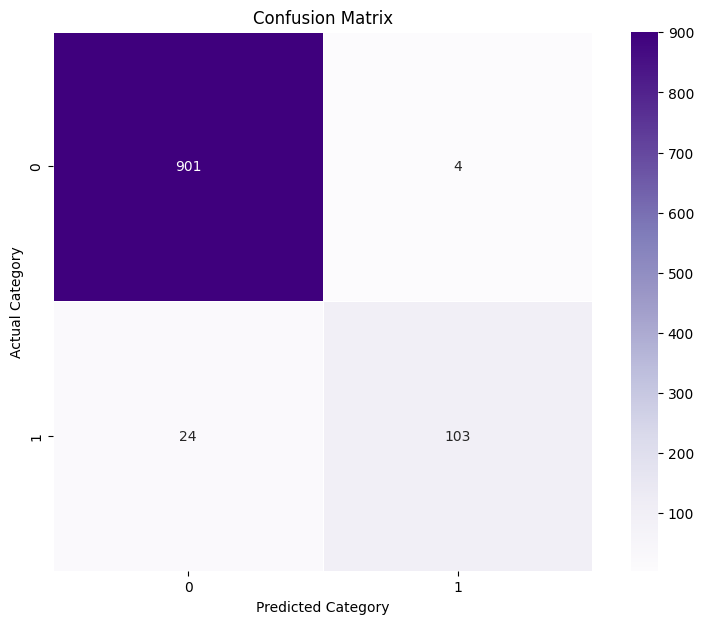

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       905
           1       0.96      0.81      0.88       127

    accuracy                           0.97      1032
   macro avg       0.97      0.90      0.93      1032
weighted avg       0.97      0.97      0.97      1032



In [174]:
# Performing predictions on the test data
Y_pred = best_model.predict(X_test)

# Creating a confusion matrix
confusionMatrix = confusion_matrix(Y_test, Y_pred)

# Create a classification report
classificationReport = classification_report(Y_test, Y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusionMatrix, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Purples')
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print(classificationReport)

In [175]:
#Loading the saved model and TF-IDF vectorizer
loadResults = joblib.load('spam_detection_model.pkl')
bestModel = loadResults['bestModel']
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')

#Fitting the TF-IDF vectorizer on the training data
tfidf_vectorizer.fit(df['preprocessed_email_data'])

#function to preprocess the sample mail
def preprocess_mail(email):
    # Tokenize the mail
    text = delete_non_ascii_and_escape(email)
    preprocessed_text = stopwords_and_punctuation_deletion(email)
    preprocessed_data = lemmatize_text(email)
    return preprocessed_data

#function to predict the given mail
def predictSpamHam(sample_mail):
    #Preprocess the sample mail
    preprocessed_sample_mail = preprocess_mail(sample_mail)

    #Vectorize the preprocessed sample mail
    vectorized_sample_mail = tfidf_vectorizer.transform([preprocessed_sample_mail])

    #Make a prediction using the best model
    sample_mail_prediction = bestModel.predict(vectorized_sample_mail)

    #Print the result
    if sample_mail_prediction[0] == 0:
        print("The given mail is ham.")
    else:
        print("The given mail is spam.")

sample_mail = "Congratulations Vasudha \nYou may be pre-approved for a LIFETIME-FREE Credit Card!\n\nNo annual fees + No joining fees\n\nNo income docs\n\nUp to 5,00,000 spend limit\n\n100% online"

predictSpamHam(sample_mail)


The given mail is spam.
